In [10]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import sys
sys.path.append('../zdrojaky')
from tsplot import tsplot

from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import acf
import statsmodels.tsa.api as smt 
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.stattools import arma_order_select_ic

import pmdarima as pm

import warnings
warnings.simplefilter(action='ignore', category=(FutureWarning, DeprecationWarning)) 

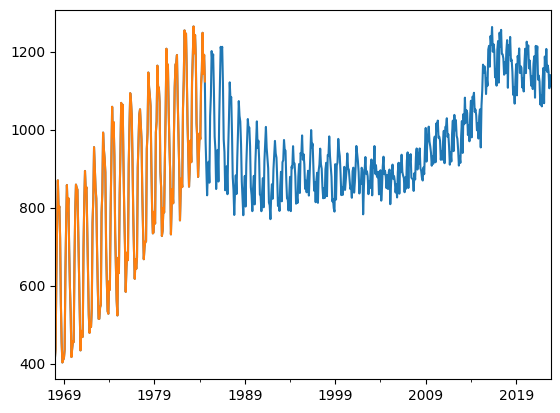

In [2]:
df = pd.read_csv("milk.tsv", delimiter="\t").T
df = df.iloc[1:,:]
df.index = pd.to_datetime(df.index)
df = pd.to_numeric(df[0])
df.plot()
df = df.iloc[:200]
df.plot()
data = df.to_numpy()
season = 12

ACF: 1.5590093918239007


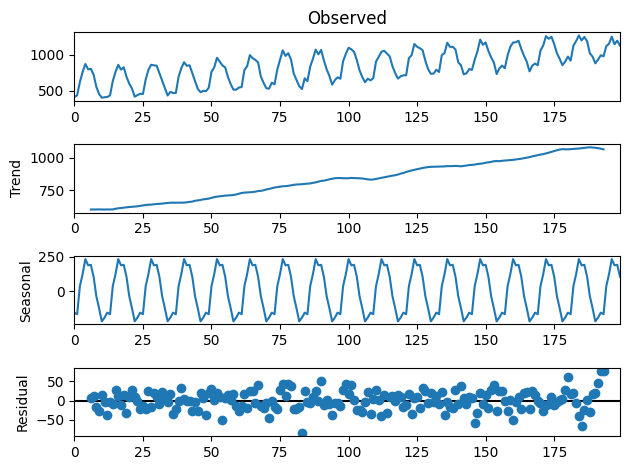

In [3]:
result = seasonal_decompose(data, period=season, model='additive')
resid_acf = acf(result.resid, nlags=season + 1, missing='drop')
sum_of_squares_resid_acf = np.sum(resid_acf**2)
print('ACF:', sum_of_squares_resid_acf)

result.plot()
plt.show() 

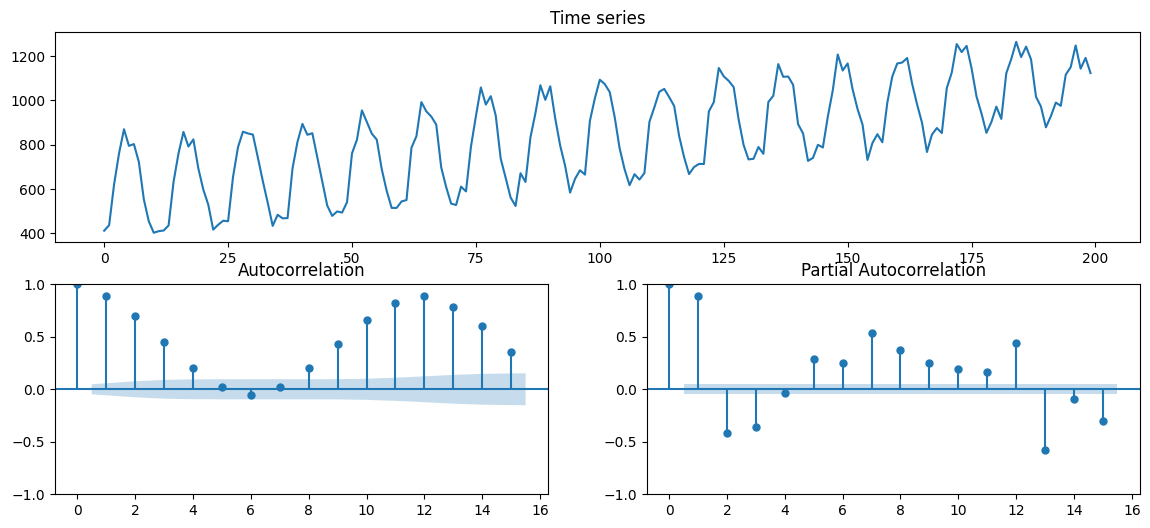

In [4]:
tsplot(data)

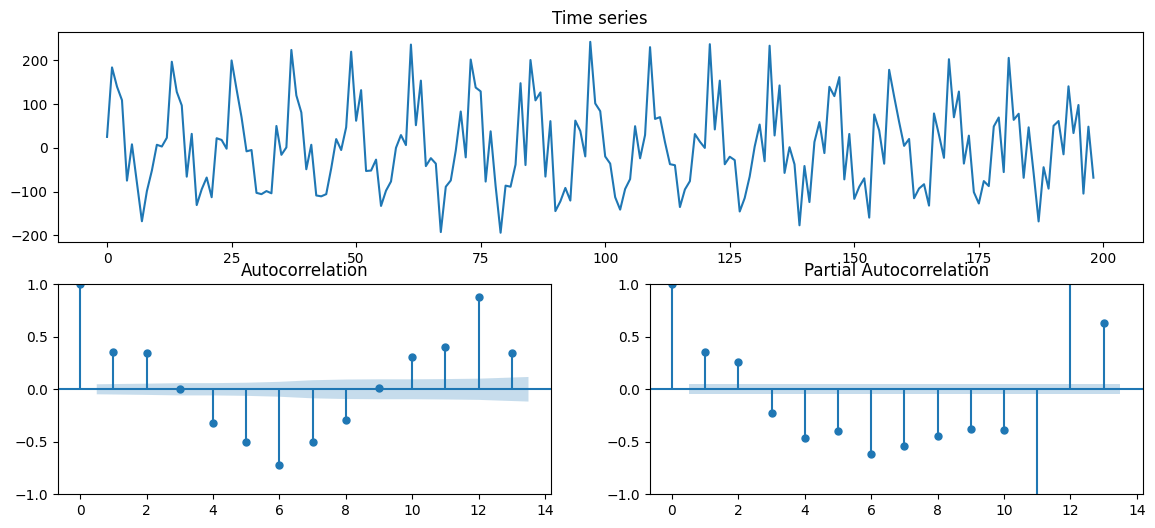

In [8]:
data_diff = np.diff(data)
data_diff = data_diff[~np.isnan(data_diff)]

tsplot(data_diff, lags=season+1)

In [11]:
stepwise_fit = pm.auto_arima(data, start_p=1, start_q=1,
                             max_p=3, max_q=3, m=season,
                             seasonal=True, trace=True, stepwise=True,
                             information_criterion='bic') 


Performing stepwise search to minimize bic
 ARIMA(1,1,1)(1,0,1)[12] intercept   : BIC=inf, Time=3.29 sec
 ARIMA(0,1,0)(0,0,0)[12] intercept   : BIC=2409.999, Time=0.02 sec
 ARIMA(1,1,0)(1,0,0)[12] intercept   : BIC=inf, Time=0.79 sec
 ARIMA(0,1,1)(0,0,1)[12] intercept   : BIC=2249.253, Time=0.85 sec
 ARIMA(0,1,0)(0,0,0)[12]             : BIC=2404.958, Time=0.02 sec
 ARIMA(0,1,1)(0,0,0)[12] intercept   : BIC=2398.635, Time=0.13 sec
 ARIMA(0,1,1)(1,0,1)[12] intercept   : BIC=1981.708, Time=1.27 sec
 ARIMA(0,1,1)(1,0,0)[12] intercept   : BIC=1986.080, Time=0.84 sec
 ARIMA(0,1,1)(2,0,1)[12] intercept   : BIC=1971.864, Time=3.65 sec
 ARIMA(0,1,1)(2,0,0)[12] intercept   : BIC=inf, Time=3.01 sec
 ARIMA(0,1,1)(2,0,2)[12] intercept   : BIC=inf, Time=5.48 sec
 ARIMA(0,1,1)(1,0,2)[12] intercept   : BIC=1969.041, Time=4.64 sec
 ARIMA(0,1,1)(0,0,2)[12] intercept   : BIC=2173.656, Time=5.03 sec
 ARIMA(0,1,0)(1,0,2)[12] intercept   : BIC=inf, Time=4.92 sec
 ARIMA(1,1,1)(1,0,2)[12] intercept   : BIC=2

In [12]:
model = ARIMA(df, order=(0,1,1), seasonal_order=(1,0,2,season), trend='n')
res = model.fit()
print(res.summary()) 

/home/sutymate/.local/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/home/sutymate/.local/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/home/sutymate/.local/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


                                       SARIMAX Results                                       
Dep. Variable:                                     y   No. Observations:                  200
Model:             ARIMA(0, 1, 1)x(1, 0, [1, 2], 12)   Log Likelihood                -968.643
Date:                               Tue, 24 Jan 2023   AIC                           1947.286
Time:                                       09:54:45   BIC                           1963.752
Sample:                                   01-01-1968   HQIC                          1953.950
                                        - 08-01-1984                                         
Covariance Type:                                 opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.5735      0.057    -10.022      0.000      -0.686      -0.461
ar.S.L12   

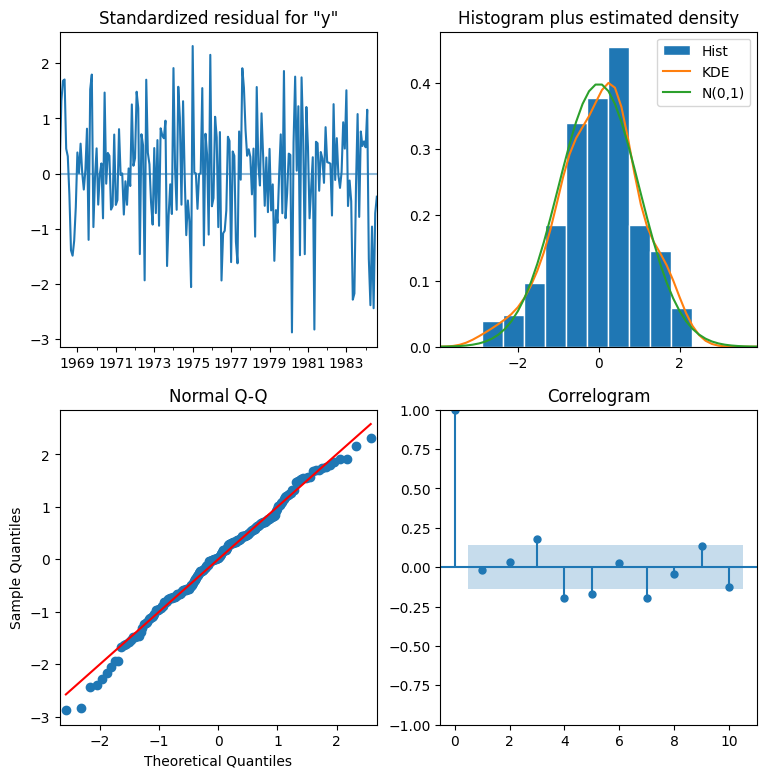

In [13]:
res.plot_diagnostics(figsize=(9,9))
plt.show() 

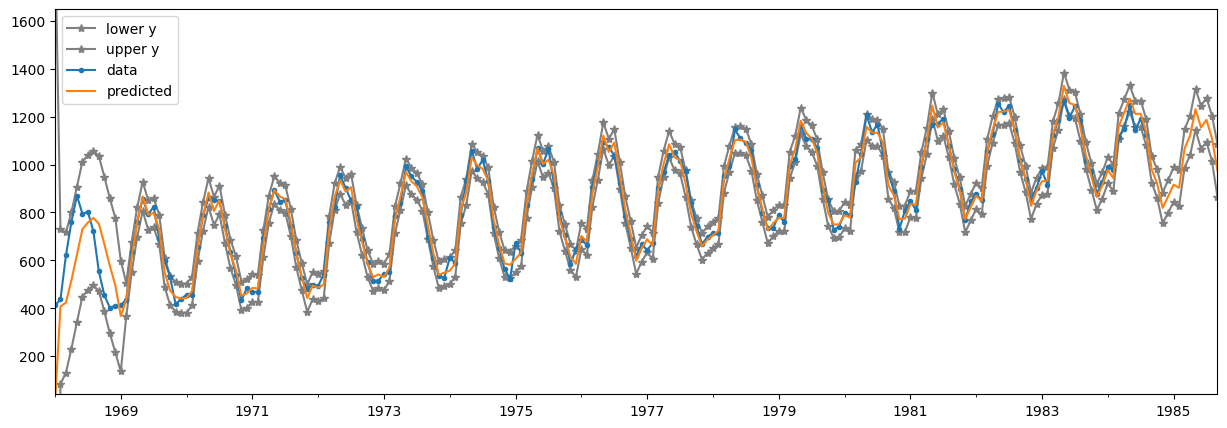

In [28]:
fcast_horizon = df.index[-1] + pd.Timedelta('1Y')
preds = res.get_prediction(end=fcast_horizon)

ci = preds.conf_int()

fig = ci.plot(color='grey', marker="*", figsize=(15, 5))
ax = plt.gca()
ax.set_ylim([0.1*df[0].min(), 4*df[0].max()])

res.data.orig_endog.plot(label='data', marker='.', fig=fig)
preds.predicted_mean.plot(label='predicted', fig=fig)
plt.legend()
plt.show() 

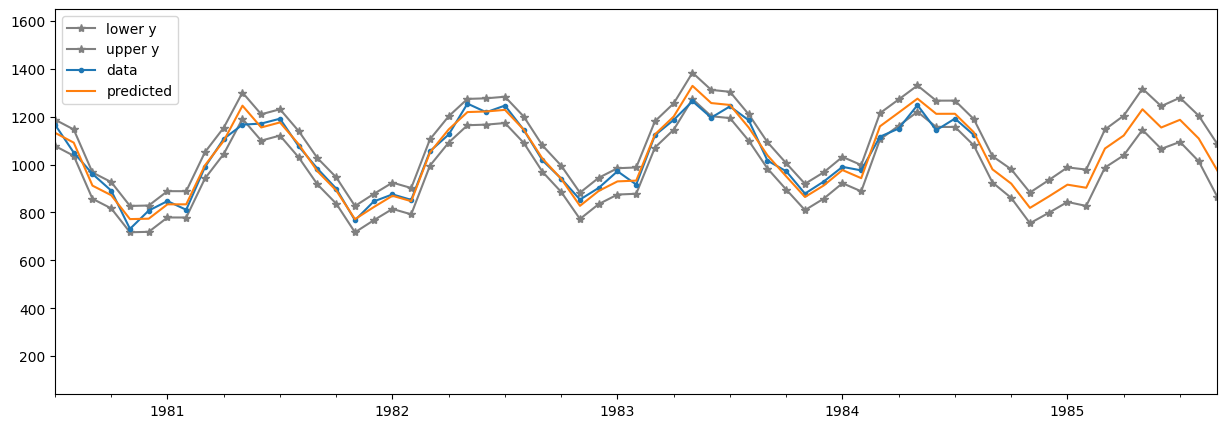

In [27]:
fcast_horizon = df.index[-1] + pd.Timedelta('1Y')
preds = res.get_prediction(end=fcast_horizon)

ci = preds.conf_int()

fig = ci[150:].plot(color='grey', marker="*", figsize=(15, 5))
ax = plt.gca()
ax.set_ylim([0.1*df[0].min(), 4*df[0].max()])

res.data.orig_endog[150:].plot(label='data', marker='.', fig=fig)
preds.predicted_mean[150:].plot(label='predicted', fig=fig)
plt.legend()
plt.show() 